## Introduction  

This is Assignment 3 for the course *Data Analysis 3: Production and Introduction to Machine Learning*.  

In this assignment, I was tasked with providing hourly forecasts for the month of November for two unknown KPIs, **V1** and **V2**.  

To approach this problem, I trained four models:  
1. An **ARIMAX** model  
2. A **VARMAX** model  
3. An **XGBoost** model  
4. A **CatBoost** model  

Through exploratory data analysis (EDA), I found that the two target variables are highly correlated, and lagged values as well as cross-lags were likely to be key predictors. Therefore, I incorporated these features in the feature engineering process.  

Because lagged features are not available for future unseen periods, I applied **recursive forecasting**, where previous predictions are fed back into the model to generate forecasts for the next time steps.  

After testing on a holdout period, the **CatBoost** model emerged as the most robust and reliable, outperforming the other models in both R² and RMSE metrics. While both metrics weakened slightly on the holdout compared to cross-validation results, diagnostic plots showed no signs of bias and indicated that the model followed the true pattern well.  

Finally, I retrained the CatBoost model on the full dataset and used it to generate recursive hourly predictions for November, followed by a feature importance analysis to understand which predictors had the strongest influence.  

In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneGroupOut, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.base import clone
from catboost import CatBoostRegressor

try: 
    import holidays
except:
    !pip install holidays
    import holidays
    
try:
    from pmdarima.arima import auto_arima
except:
    !pip install pmdarima
    from pmdarima.arima import auto_arima

%matplotlib inline
%precision 4   
warnings.filterwarnings("ignore")

In [2]:
# Load the data
df = pd.read_csv("https://media.githubusercontent.com/media/ghadena/DA3/refs/heads/main/assignment_3/data.csv", parse_dates=['ts'], index_col='ts')

## Helper Functions and Model Wrappers
- I defined two main helper functions:  
  1. **Rolling window split proportions:**  
     - Inputs: number of samples, train fraction, test fraction, number of folds.  
     - I use rolling windows instead of random or simple splits to handle the large sample size and better simulate real forecasting setups.  
  2. **Cross-validation function using rolling splits:**  
     - Inputs: model parameters, exogenous features, targets, number of folds, train/test fractions.  
     - The function runs cross-validation and returns a dataframe with per-fold RMSE, R², and average metrics.  
     - This setup allows me to evaluate model stability and avoid overfitting.  

- I also define model wrappers for **ARIMAX** and **VARMAX** models.  
  - These wrappers standardize the fit and predict process across different models.  
  - They make it easier to loop through models in cross-validation and ensure clean, reproducible forecasts.  
  - This structure simplifies switching between models and testing them consistently with the same data splits and exogenous features.

In [3]:

def rolling_window_split_proportions(n_samples, train_frac, test_frac, n_folds):
    """
    Generates train/test indices for a rolling window cross-validation 
    based on proportions of the total number of samples.
    
    Parameters:
      n_samples : Total number of samples.
      train_frac: Fraction of n_samples to use for training.
      test_frac : Fraction of n_samples to use for testing.
      n_folds   : Desired number of folds.
      
    Returns:
      A list of (train_indices, test_indices) tuples.
    """
    # Compute window sizes based on proportions.
    train_window = int(n_samples * train_frac)
    test_window = int(n_samples * test_frac)
    
    # Compute step so that we get exactly n_folds splits.
    if n_folds > 1:
        step = (n_samples - (train_window + test_window)) // (n_folds - 1)
    else:
        step = 0  
    
    splits = []
    for i in range(n_folds):
        start = i * step
        train_idx = np.arange(start, start + train_window)
        test_idx  = np.arange(start + train_window, start + train_window + test_window)
        # If the test indices go beyond available samples, break out.
        if test_idx[-1] >= n_samples:
            break
        splits.append((train_idx, test_idx))
    return splits

# Test the function
n_samples = 23152  
train_frac = 0.60  
test_frac  = 0.20  
n_folds    = 5     

splits = rolling_window_split_proportions(n_samples, train_frac, test_frac, n_folds)
print("Generated Splits:")
for i, (train_idx, test_idx) in enumerate(splits):
    print(f"Fold {i}: Train indices {train_idx[0]} to {train_idx[-1]}, "
          f"Test indices {test_idx[0]} to {test_idx[-1]}")
    


Generated Splits:
Fold 0: Train indices 0 to 13890, Test indices 13891 to 18520
Fold 1: Train indices 1157 to 15047, Test indices 15048 to 19677
Fold 2: Train indices 2314 to 16204, Test indices 16205 to 20834
Fold 3: Train indices 3471 to 17361, Test indices 17362 to 21991
Fold 4: Train indices 4628 to 18518, Test indices 18519 to 23148


In [4]:
def cross_validate_model_rolling_proportions(model, X_exog, y, train_frac, test_frac, n_folds):
    """
    Cross-validates a model using a rolling window approach defined by proportions.
    
    Parameters:
      model     : An object with .fit(X, y) and .predict(X) methods.
      X_exog    : pd.DataFrame of exogenous features.
      y         : Target variable (pd.Series for univariate, pd.DataFrame for multivariate).
      train_frac: Fraction of total samples used for training in each fold.
      test_frac : Fraction of total samples used for testing in each fold.
      n_folds   : Desired number of folds.
      
    Returns:
      results_df  : DataFrame with per-fold RMSE and R².
      avg_metrics : Series with average metrics across folds.
    """

    n_samples = len(y)
    splits = rolling_window_split_proportions(n_samples, train_frac, test_frac, n_folds)
    fold_results = []
    
    
    for fold, (train_idx, test_idx) in enumerate(splits):
        
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train, X_test = X_exog.iloc[train_idx], X_exog.iloc[test_idx]
        
        # Reset indices so that training and test sets start at 0
        y_train = y_train.reset_index(drop=True)
        y_test  = y_test.reset_index(drop=True)
        X_train = X_train.reset_index(drop=True)
        X_test  = X_test.reset_index(drop=True)
        
        try:
            # Fit the model on the training data
            model.fit(X_train, y_train)
            # Predict on the test data
            preds = model.predict(X_test)
            
            # Calculate RMSE and R²
            if isinstance(y, pd.DataFrame):
                metrics = {}
                for col in y.columns:
                    rmse = np.sqrt(mean_squared_error(y_test[col], preds[col]))
                    r2   = r2_score(y_test[col], preds[col])
                    metrics[f'{col}_rmse'] = rmse
                    metrics[f'{col}_r2'] = r2
                print(f"Fold {fold}: {metrics}")
                fold_results.append(metrics)
            else:
                rmse = np.sqrt(mean_squared_error(y_test, preds))
                r2   = r2_score(y_test, preds)
                print(f"Fold {fold}: RMSE={rmse:.4f}, R²={r2:.4f}")
                fold_results.append({'rmse': rmse, 'r2': r2})
        except Exception as e:
            print(f"Fold {fold} failed: {e}")
    
    results_df = pd.DataFrame(fold_results)
    avg_metrics = results_df.mean()
    print("\nAverage Metrics (Rolling Proportions):")
    print(avg_metrics)
    return results_df, avg_metrics

In [5]:
# ARIMAX wrapper (for univariate forecasting)
class ARIMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,0,1), trend='n'):
        self.order = order
        self.trend = trend
        self.model_fit_ = None

    def fit(self, X, y):
        # X: exogenous features, y: target series (pd.Series)
        self.model_ = ARIMA(y, exog=X, order=self.order, trend=self.trend)
        self.model_fit_ = self.model_.fit()
        return self

    def predict(self, X):
        # Predict the next len(X) steps using exogenous features X
        steps = len(X)
        forecast = self.model_fit_.forecast(steps=steps, exog=X)
        return forecast

# VARMAX wrapper (for multivariate forecasting)
class VARMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,0), trend='n'):
        self.order = order
        self.trend = trend
        self.model_fit_ = None

    def fit(self, X, y):
        # Here, y is a DataFrame (with, e.g., v1 and v2), and X are exogenous features.
        self.model_ = VARMAX(y, exog=X, order=self.order, trend=self.trend)
        self.model_fit_ = self.model_.fit(disp=False)
        return self

    def predict(self, X):
        steps = len(X)
        forecast = self.model_fit_.forecast(steps=steps, exog=X)
        return forecast

## Exploratory Data Analysis (EDA) 

### Correlation
- Correlation between v1 and v2 is 0.91.  
- The two KPIs move closely together.  
- This supports using cross-lag features to let each model learn from the other variable.  

### Rolling Means
- Plotted 7-day rolling averages for v1 and v2.  
- Strong growth in 2022, then stabilization.  
- Clear drop in January every year.  
- No regular seasonality beyond that.  
- Decided to use holiday indicators and trend features instead of seasonal components.  

### Stationarity
- Ran ADF tests on both v1 and v2.  
- Both series are stationary.  
- Confirms that using lag features and rolling statistics is appropriate.  
- No need for differencing.  

### Time Series Decomposition  

I perform time series decomposition to break down each series into trend, seasonal, and residual components. This helps verify whether seasonality is present and if trend patterns need to be captured explicitly.  

**Findings:**  
- The **trend component** reflects strong growth throughout 2022, followed by stabilization from 2023 onwards.  
- The **seasonal component** is noisy, without clear or consistent patterns across time.  
- The **residuals** are random, with no noticeable structure or persistent patterns.  

**Implications for modeling:**  
- I include polynomial trend features (`trend`, `trend_sq`) to account for the observed growth and plateau.  
- I do not add seasonal features or seasonal terms, as decomposition does not show meaningful or repeatable seasonality.  
- I focus on capturing short-term fluctuations and long-term trends rather than building in forced seasonal structures.  

> In short, time series decomposition confirms the presence of a long-term trend and random short-term variations, without consistent seasonal behavior.

### ACF and PACF Analysis  

I use ACF and PACF plots to examine autocorrelation structures and identify whether short- or medium-term memory exists in the series. This step guides lag feature selection and helps decide if seasonal modeling is necessary.  

**Findings:**  
- The **ACF** plots show smooth, wave-like patterns with peaks around lag 24, indicating mild cyclical effects. The gradual decay suggests persistent medium-term memory rather than clear, repetitive seasonality.  
- The **PACF** plots display a strong spike at lag 1, confirming that the most immediate past values are highly predictive. Minor bumps around lag 20–24 appear but lack consistency for seasonal modeling.  

**Implications for modeling:**  
- I rely on these insights to include `lag1` and `lag24` features for both v1 and v2.  
- I implement rolling window statistics (24-hour means and standard deviations) to capture local trends and volatility.  
- I avoid unnecessary complexity by excluding explicit seasonal dummies or SARIMA terms, as the evidence does not support strong seasonality.  

> In short, ACF and PACF analysis confirms short- and medium-term dependencies and justifies the focus on lag features and rolling statistics without seasonal components.

Correlation Matrix:
           v1        v2
v1  1.000000  0.911494
v2  0.911494  1.000000


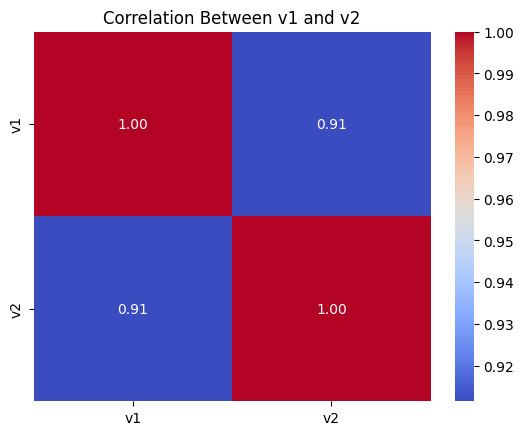

In [6]:
# Calculate correlation
correlation = df[['v1', 'v2']].corr()
print("Correlation Matrix:\n", correlation)

# Visualize correlation
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between v1 and v2")
plt.show()

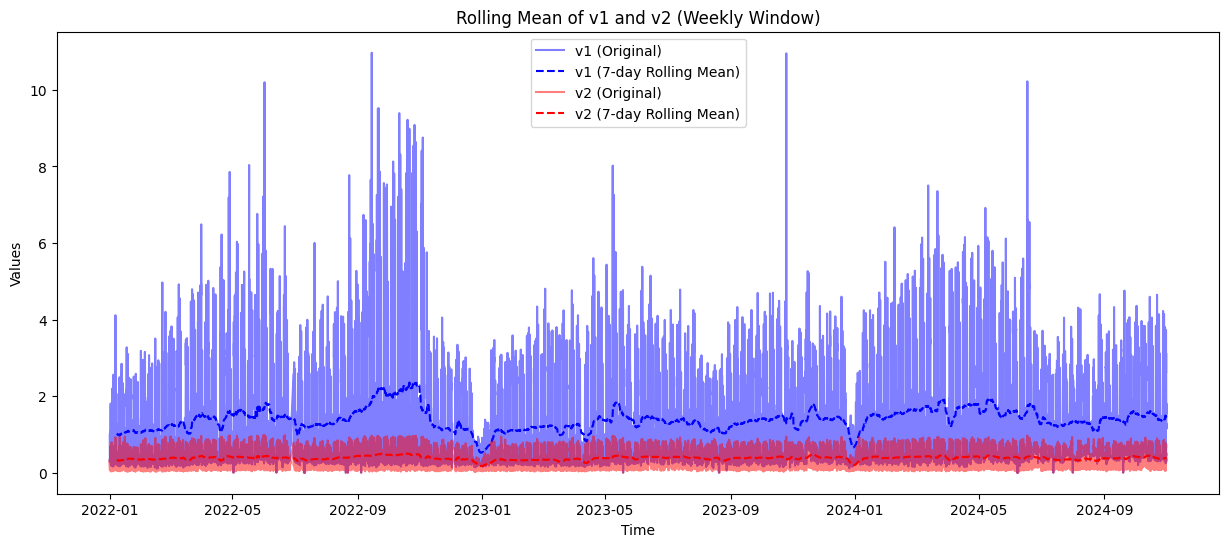

In [7]:
# Rolling mean and standard deviation
window_size = 24 * 7  # Weekly window
df_rolling = df[['v1', 'v2']].rolling(window=window_size).mean()

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['v1'], alpha=0.5, label="v1 (Original)", color="blue")
plt.plot(df_rolling.index, df_rolling['v1'], label="v1 (7-day Rolling Mean)", color="blue", linestyle="dashed")
plt.plot(df.index, df['v2'], alpha=0.5, label="v2 (Original)", color="red")
plt.plot(df_rolling.index, df_rolling['v2'], label="v2 (7-day Rolling Mean)", color="red", linestyle="dashed")
plt.legend()
plt.title("Rolling Mean of v1 and v2 (Weekly Window)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("✅ The time series is stationary (p < 0.05)")
    else:
        print("❌ The time series is NOT stationary (p >= 0.05)")

print("ADF Test for v1:")
adf_test(df['v1'])

print("\nADF Test for v2:")
adf_test(df['v2'])

ADF Test for v1:
ADF Statistic: -20.69186073853296
p-value: 0.0000
✅ The time series is stationary (p < 0.05)

ADF Test for v2:
ADF Statistic: -20.598352688554975
p-value: 0.0000
✅ The time series is stationary (p < 0.05)


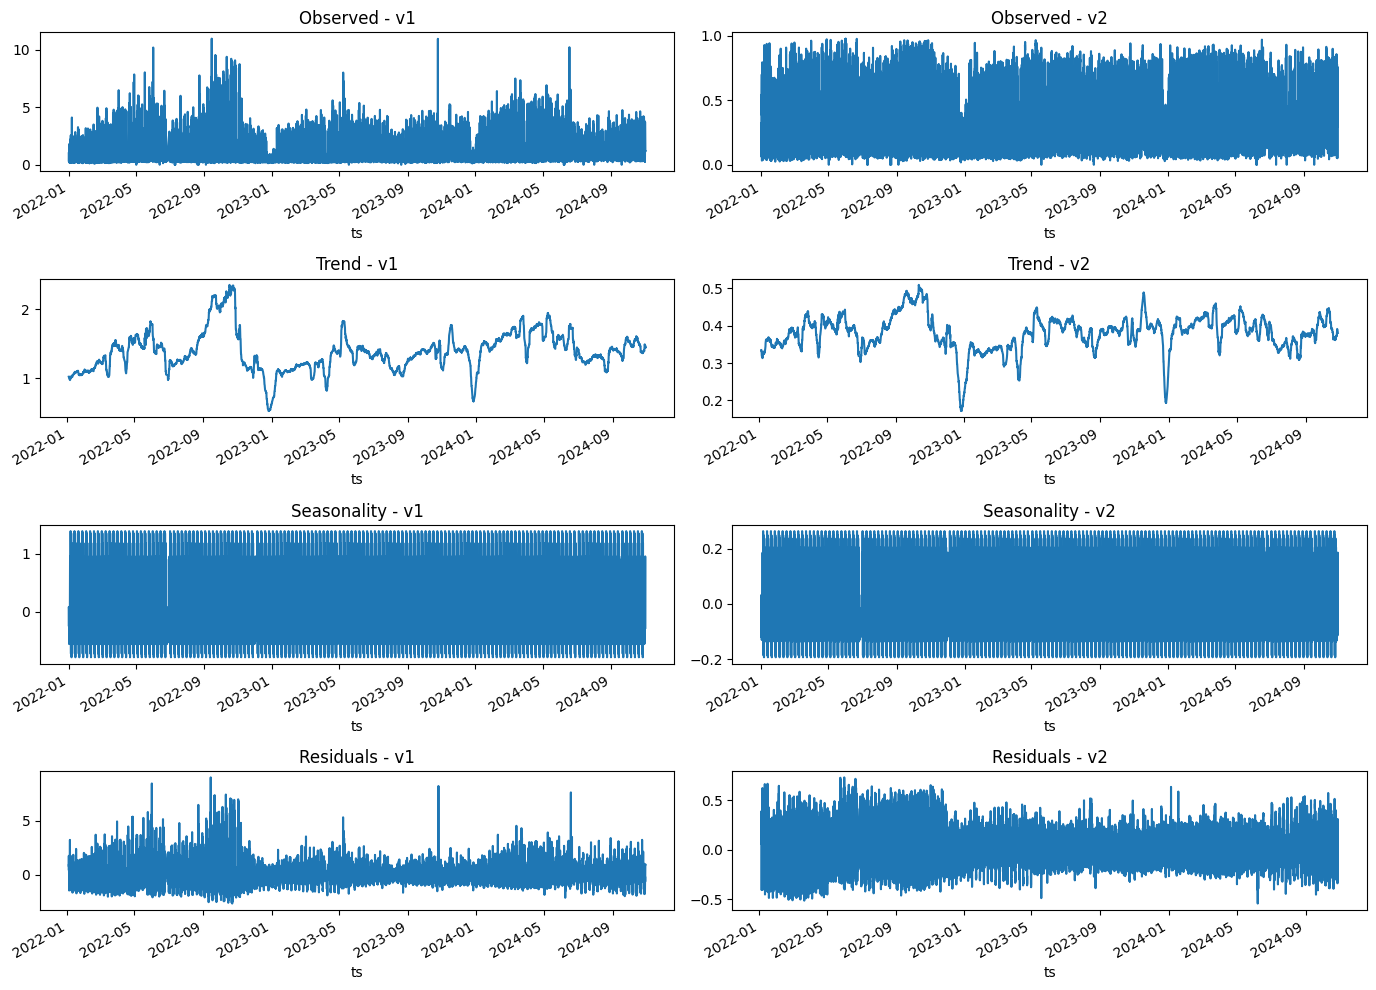

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose v1 and v2
result_v1 = seasonal_decompose(df['v1'], model='additive', period=24*7)
result_v2 = seasonal_decompose(df['v2'], model='additive', period=24*7)

# Plot decomposition
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# v1 decomposition
result_v1.observed.plot(ax=axes[0, 0], title="Observed - v1")
result_v1.trend.plot(ax=axes[1, 0], title="Trend - v1")
result_v1.seasonal.plot(ax=axes[2, 0], title="Seasonality - v1")
result_v1.resid.plot(ax=axes[3, 0], title="Residuals - v1")

# v2 decomposition
result_v2.observed.plot(ax=axes[0, 1], title="Observed - v2")
result_v2.trend.plot(ax=axes[1, 1], title="Trend - v2")
result_v2.seasonal.plot(ax=axes[2, 1], title="Seasonality - v2")
result_v2.resid.plot(ax=axes[3, 1], title="Residuals - v2")

plt.tight_layout()
plt.show()

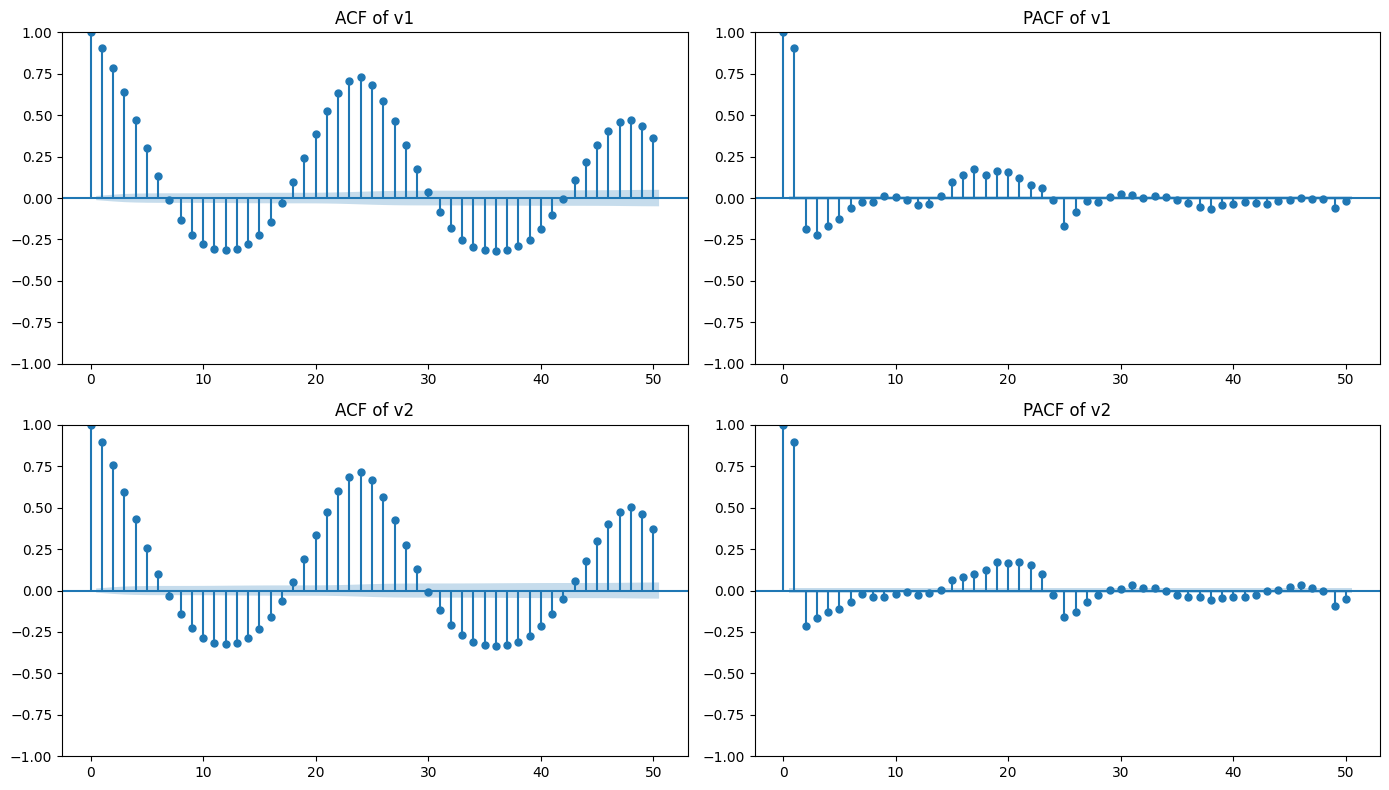

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF and PACF for v1
plot_acf(df['v1'].dropna(), ax=axes[0, 0], lags=50)
axes[0, 0].set_title("ACF of v1")
plot_pacf(df['v1'].dropna(), ax=axes[0, 1], lags=50)
axes[0, 1].set_title("PACF of v1")

# ACF and PACF for v2
plot_acf(df['v2'].dropna(), ax=axes[1, 0], lags=50)
axes[1, 0].set_title("ACF of v2")
plot_pacf(df['v2'].dropna(), ax=axes[1, 1], lags=50)
axes[1, 1].set_title("PACF of v2")

plt.tight_layout()
plt.show()

## Feature Engineering  

- **Time-based features:**  
  - Extracted `year`, `quarter`, `month`, `day`, `hour`, `dayofweek`, and `weekend`.  

- **Cyclical encoding:**  
  - Applied to `hour` and `dayofweek` using sine and cosine transformations.  
  - This was done to reflect the cyclical nature of time features (e.g., hour 23 and hour 0 should be close).  

- **Cross-lags:**  
  - Added `v1_from_v2_lag1` and `v2_from_v1_lag1` to allow each model to use the other variable’s most recent past value, because v1 and v2 are highly correlated (corr = 0.91).  

- **Rolling window statistics:**  
  - Calculated 24-hour moving averages and standard deviations (`v1_roll24_mean`, `v1_roll24_std`, `v2_roll24_mean`, `v2_roll24_std`) to capture recent volatility and trends.  
  - This helps the model smooth out noise and understand short-term dynamics.  

- **Trend features:**  
  - Added a `trend` variable (linear time index) and `trend_sq` to help capture long-term patterns and gradual changes over time.  

- **Holiday indicators:**  
  - Included `is_eu_holiday` and `is_us_holiday` features to account for demand patterns changing around holidays.  

In [11]:
# Generate Time-Based Features
df["year"] = df.index.year
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["day"] = df.index.day
df['hour'] = df.index.hour
df["dayofweek"] = df.index.dayofweek + 1
df['weekend'] = (df['dayofweek'] >= 5).astype(int)

# Cyclical Time Encoding 
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Extract holidays 
df["is_eu_holiday"] = df.index.normalize().isin(
    {d for country in ["FR", "ES", "IT", "AT"] for d in holidays.CountryHoliday(country, years=[2022, 2023, 2024])})

df["is_us_holiday"] = df.index.normalize().isin(
    holidays.US(years=[2022, 2023, 2024]))

# Lagged features 
df['v1_lag1'] = df['v1'].shift(1)
df['v2_lag1'] = df['v2'].shift(1)
# 24 hours lags (to capture daily cycles)
df['v1_lag24'] = df['v1'].shift(24)
df['v2_lag24'] = df['v2'].shift(24)

# Cross lags 
df['v1_from_v2_lag1'] = df['v2'].shift(1)
df['v2_from_v1_lag1'] = df['v1'].shift(1)

# Moving average
df['v1_roll24_mean'] = df['v1'].rolling(window=24).mean()
df['v2_roll24_mean'] = df['v2'].rolling(window=24).mean()
df['v1_roll24_std'] = df['v1'].rolling(window=24).std()
df['v2_roll24_std'] = df['v2'].rolling(window=24).std()

# Trends 
df['trend'] = np.arange(len(df))
df['trend_sq'] = df['trend'] ** 2

## Work and Holdout Sets  
- Created a holdout split to simulate the challenge setup:  
  - First tried a two-month holdout.  
  - Final holdout was the last month (October 2024), to mimic the competition scenario.  
  - All model tuning and validation were done excluding this holdout period.  
  - The model diagnostics were done on the holdout period 
  - The model was retrained on the full data (including October 2024) before making predictions for November period 

In [12]:
df_holdout = df[(df['year'] == 2024) & (df['month'].isin([10]))]
df_work = df[(df['year'] < 2024) | ((df['year'] == 2024) & (~df['month'].isin([10])))]

print(f"- Work set size: {df_work.shape[0]} rows")
print(f"- Holdout set size: {df_holdout.shape[0]} rows")

- Work set size: 23848 rows
- Holdout set size: 744 rows


## Exogenous Features and Target Definition  

I define the exogenous feature set using all engineered features from the feature engineering step. This includes time-based features (year, month, day, hour, day of week, weekend), cyclical encodings (hour_sin, hour_cos, dayofweek_sin, dayofweek_cos), holiday indicators, lag features, cross-lags, rolling window statistics, and trend terms.  

All boolean indicators are converted to integers, and I ensure all columns are numeric. I also drop any rows with missing values to keep alignment between exogenous features and target variables.  

Finally, I define `v1_train` and `v2_train` to match these cleaned and aligned features. Using this structured exogenous feature set helps the models capture time structure, short-term memory, long-term trends, and relationships between v1 and v2, enhancing forecast accuracy.

In [13]:
# Define exogenous feature df 
exog_features = df_work[[
    'year','quarter','month','day','hour', 'dayofweek', 'weekend',
    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 
    'is_eu_holiday','is_us_holiday',
    'v1_lag1','v2_lag1','v1_lag24', 'v2_lag24', 
    'v1_from_v2_lag1','v2_from_v1_lag1',
    'v1_roll24_std','v2_roll24_std','v1_roll24_mean','v2_roll24_mean',
    'trend','trend_sq'
]].copy()

# Convert booleans to int 
exog_features['is_eu_holiday'] = exog_features['is_eu_holiday'].astype(int)
exog_features['is_us_holiday'] = exog_features['is_us_holiday'].astype(int)

# Ensure all columns are numeric
exog_features = exog_features.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values (to ensure alignment between exog and target)
mask = exog_features.notnull().all(axis=1)
exog_features = exog_features[mask]

# Define target variable series 
v1_train = df_work.loc[mask, 'v1']
v2_train = df_work.loc[mask, 'v2']

## ARIMAX Model and Cross-Validation  

I define the ARIMAX model with an order of (1,0,1) and no constant trend term. After testing different configurations through grid search and trial and error, this order performed best. The AR(1) term captures short-term autocorrelation identified in the PACF plots, and the MA(1) term helps account for short-term noise.  

I cross-validate the model using rolling proportions for both v1 and v2.  

**Results for v1:**  
- Average metrics:  
  - RMSE = 0.4207  
  - R² = 0.8709  

**Results for v2:**  
- Average metrics:  
  - RMSE = 0.0840  
  - R² = 0.8622  

The RMSE for v2 is much lower than for v1, even though both models achieve similar R² scores. This difference is due to scale — v2 operates on a smaller scale. While the relative performance (R²) is comparable, the absolute errors (RMSE) are lower for v2 simply because its values are smaller.  

Other factors contributing to the difference include lower noise levels and tighter data distribution for v2. In short, v2 is easier to predict in absolute terms, but both models show strong relative predictive performance.

In [14]:
# Define model
arimax_model = ARIMAXRegressor(order=(1,0,1), trend='n')

# Cross-validate the models
print('CV of model on V1')
cv_results_prop, avg_metrics_prop = cross_validate_model_rolling_proportions(
    model=arimax_model,  
    X_exog=exog_features,      
    y=v1_train,            
    train_frac=train_frac,
    test_frac=test_frac,
    n_folds=n_folds
)


print('CV of model on V2')
cv_results_prop, avg_metrics_prop = cross_validate_model_rolling_proportions(
    model=arimax_model,  
    X_exog=exog_features,      
    y=v2_train,            
    train_frac=train_frac,
    test_frac=test_frac,
    n_folds=n_folds
)

CV of model on V1
Fold 0: RMSE=0.3823, R²=0.8670
Fold 1: RMSE=0.4146, R²=0.8761
Fold 2: RMSE=0.4452, R²=0.8744
Fold 3: RMSE=0.4394, R²=0.8735
Fold 4: RMSE=0.4217, R²=0.8634

Average Metrics (Rolling Proportions):
rmse    0.420661
r2      0.870892
dtype: float64
CV of model on V2
Fold 0: RMSE=0.0833, R²=0.8580
Fold 1: RMSE=0.0838, R²=0.8655
Fold 2: RMSE=0.0852, R²=0.8667
Fold 3: RMSE=0.0829, R²=0.8690
Fold 4: RMSE=0.0848, R²=0.8517

Average Metrics (Rolling Proportions):
rmse    0.084012
r2      0.862182
dtype: float64


## VARMAX Model and Cross-Validation  

I define the endogenous data frame for the VARMAX model using both v1 and v2. This allows the model to capture the dynamic relationships between the two KPIs over time. The model is set up with an order of (3,0), chosen after testing different lag orders. The choice of p=3 is based on the observed autocorrelation patterns and the need to capture multi-step dependencies between the two series.  

I run cross-validation using rolling proportions to evaluate the model’s performance.  

**Results:**  
- Average metrics:  
  - v1: RMSE = 0.4499, R² = 0.8525  
  - v2: RMSE = 0.0864, R² = 0.8541  

The RMSE values for v2 are smaller than for v1, similar to what I observed with the ARIMAX model. This is expected due to v2 operating on a smaller scale. While absolute errors are lower for v2, the relative performance measured by R² is consistent across both variables, indicating stable model performance in proportionate terms. Compared to the ARIMAX model, this model had a weaker RMSE and R². 

In [27]:
# Define endogenous DataFrame for the VAR model (v1 and v2)
df_endog = df_work[['v1', 'v2']].copy()
df_endog = df_work.loc[mask, ['v1', 'v2']]

# Define a VARMAX
varmax = VARMAXRegressor(order=(3,0), trend='n')

# Run cross-validation 
cv_results_var, avg_metrics_var = cross_validate_model_rolling_proportions(
    model=varmax,
    X_exog=exog_features,      
    y=df_endog,               
    train_frac=train_frac, 
    test_frac=test_frac,
    n_folds=n_folds
)

Fold 0: {'v1_rmse': 0.40199202107831294, 'v1_r2': 0.8530223756394355, 'v2_rmse': 0.08493676400616676, 'v2_r2': 0.8523068758600174}
Fold 1: {'v1_rmse': 0.4449470505958049, 'v1_r2': 0.8572784371506592, 'v2_rmse': 0.08608467130976921, 'v2_r2': 0.8582595214912354}
Fold 2: {'v1_rmse': 0.47722591506983464, 'v1_r2': 0.8557376015453135, 'v2_rmse': 0.08774048538226764, 'v2_r2': 0.858654641316229}
Fold 3: {'v1_rmse': 0.4760565731988409, 'v1_r2': 0.851546757165827, 'v2_rmse': 0.08618008190560451, 'v2_r2': 0.8584707740469792}
Fold 4: {'v1_rmse': 0.44916937833769627, 'v1_r2': 0.8450151748910407, 'v2_rmse': 0.0872653813864411, 'v2_r2': 0.8429681914463361}

Average Metrics (Rolling Proportions):
v1_rmse    0.449878
v1_r2      0.852520
v2_rmse    0.086441
v2_r2      0.854132
dtype: float64


## XGBoost Model and Cross-Validation  

I set up an XGBoost model with parameters chosen through experimentation and tuning. A small learning rate and a larger number of estimators help capture complex patterns while avoiding overfitting. I use a max depth of 8 to allow the model to learn deeper feature interactions. Subsampling and column sampling are set to 0.8 to further reduce overfitting, and gamma is used as a regularization parameter.  

Since both v1 and v2 contain values that can vary significantly in scale, I log-transform the target variables before fitting the model to stabilize variance and improve performance.  

I run cross-validation with rolling proportions for both v1 and v2.  

**Results for v1:**  
- Average metrics:  
  - RMSE = 0.1107  
  - R² = 0.9264  

**Results for v2:**   
- Average metrics:  
  - RMSE = 0.0557  
  - R² = 0.8786  

In [ ]:
# Define an XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,  
    learning_rate=0.01,  
    max_depth=8,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    gamma=1,  
    objective="reg:squarederror",
    random_state=42
)

y_train_log_v1 = np.log1p(v1_train)
y_train_log_v2 = np.log1p(v2_train)

print("v1")
cv_results_xgb, avg_metrics_xgb = cross_validate_model_rolling_proportions(
    model=xgb_model,
    X_exog=exog_features,  
    y=y_train_log_v1,                  
    train_frac=train_frac,                 
    test_frac=test_frac,                
    n_folds=n_folds                        
)

print("v2")
cv_results_xgb, avg_metrics_xgb = cross_validate_model_rolling_proportions(
    model=xgb_model,
    X_exog=exog_features, 
    y=y_train_log_v2,                  
    train_frac=train_frac,                 
    test_frac=test_frac,                  
    n_folds=n_folds                       
)

v1
Fold 0: RMSE=0.1061, R²=0.9255
Fold 1: RMSE=0.1095, R²=0.9296
Fold 2: RMSE=0.1126, R²=0.9312
Fold 3: RMSE=0.1109, R²=0.9301
Fold 4: RMSE=0.1142, R²=0.9157

Average Metrics (Rolling Proportions):
rmse    0.110665
r2      0.926408
dtype: float64
v2
Fold 0: RMSE=0.0543, R²=0.8807
Fold 1: RMSE=0.0551, R²=0.8834
Fold 2: RMSE=0.0559, R²=0.8842
Fold 3: RMSE=0.0558, R²=0.8803
Fold 4: RMSE=0.0574, R²=0.8644

Average Metrics (Rolling Proportions):
rmse    0.055713
r2      0.878603
dtype: float64


## CatBoost Model and Cross-Validation

I initially tested an **XGBoost** model with parameters selected through experimentation and tuning. While it performed well in cross-validation, I found that it was not well-suited for **recursive forecasting**, where lagged predictions feed future predictions and errors can propagate.  

### Switching to CatBoost

As a result, I switched to **CatBoost**, a more robust gradient boosting method designed to handle noisy datasets, lagged features, and recursive setups more effectively. CatBoost reduces overfitting risks and has built-in ordered boosting to prevent target leakage.  

> **Side note:** Recursive forecasting requires stability across sequential predictions, and CatBoost proved more reliable than XGBoost in this context.

### Model Setup

I used a **CatBoostRegressor** with:  
- 1,500 iterations  
- Learning rate of 0.01  
- Tree depth of 6  
- l2_leaf_reg = 3 for regularization  
- Early stopping with od_type="Iter" and od_wait=50  
- Loss function: RMSE  

> This setup balances stability, predictive power, and robustness against error buildup.

### Log Transformation of Targets

I applied a log transformation to both `v1` and `v2` to stabilize variance and improve predictive accuracy.

### Cross-Validation Results with CatBoost

**Results for v1:** 
- Average metrics: 
    - RMSE = 0.1042 
    - R² = 0.9346  

**Results for v2:**   
- Average metrics: 
    - RMSE = 0.0483 
    - R² = 0.9085 

As with the other models, v2 shows a lower RMSE than v1 due to its smaller scale. Despite that, both models achieve strong relative performance, indicated by consistently high R² values. The boosted model captures nonlinear patterns and interactions effectively, resulting in higher R² values compared to the linear models.

In [17]:
# Define target variables
v1_train = df_work.loc[exog_features.index, 'v1']
v2_train = df_work.loc[exog_features.index, 'v2']

# Log-transform the target variables
y_train_log_v1 = np.log1p(v1_train)
y_train_log_v2 = np.log1p(v2_train)

In [ ]:
# Define a CatBoost model
cat_boost_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.01,
    depth=6,                # Lower depth to avoid recursive error explosion
    l2_leaf_reg=3,  
    loss_function='RMSE',
    random_seed=42,
    od_type="Iter",         # Early stopping by monitoring iterations
    od_wait=50,             # Wait for 50 rounds of no improvement before stopping
    verbose=0
)

# Run cross-validation
print("v1")
cv_results_catv1, avg_metrics_cav1 = cross_validate_model_rolling_proportions(
    model=cat_boost_model,
    X_exog=exog_features,  
    y=y_train_log_v1,                 
    train_frac=train_frac,                
    test_frac=test_frac,                 
    n_folds=n_folds                       
)

print("v2")
cv_results_catv2, avg_metrics_catv2 = cross_validate_model_rolling_proportions(
    model=cat_boost_model,
    X_exog=exog_features,  
    y=y_train_log_v2,                 
    train_frac=train_frac,                 
    test_frac=test_frac,                  
    n_folds=n_folds                     
)

# Fit models on full training data (log-transformed targets)
final_cat_v1 = clone(cat_boost_model).fit(exog_features, y_train_log_v1)
final_cat_v2 = clone(cat_boost_model).fit(exog_features, y_train_log_v2)

v1
Fold 0: RMSE=0.1017, R²=0.9316
Fold 1: RMSE=0.1042, R²=0.9361
Fold 2: RMSE=0.1049, R²=0.9403
Fold 3: RMSE=0.1027, R²=0.9401
Fold 4: RMSE=0.1075, R²=0.9253

Average Metrics (Rolling Proportions):
rmse    0.104211
r2      0.934671
dtype: float64
v2
Fold 0: RMSE=0.0479, R²=0.9074
Fold 1: RMSE=0.0478, R²=0.9122
Fold 2: RMSE=0.0478, R²=0.9153
Fold 3: RMSE=0.0475, R²=0.9134
Fold 4: RMSE=0.0506, R²=0.8945

Average Metrics (Rolling Proportions):
rmse    0.048324
r2      0.908554
dtype: float64


## Diagnostics on the Holdout Set  

To simulate the challenge environment, I performed diagnostics on the holdout period. Since my model relies on lagged features, I used **recursive prediction**, which means that each prediction feeds into the next step as input. This approach replicates real-life forecasting conditions, where future lag values are unknown and need to be replaced with model-generated predictions.  

The process worked as follows:  
- I started from the **last known data point before the holdout period**.  
- In the holdout dataframe, I inserted **placeholders (NaNs)** for lagged features and rolling statistics.  
- For each hourly step in the holdout period, I retrieved lagged features either from historical data or, when unavailable, from previously stored recursive predictions.  
- I added **cross-lags** in the same way, using the lag of the other variable as a predictor.  
- Rolling means and standard deviations over the last 24 hours were calculated where possible; otherwise, I used fallback values.  
- Predictions were then made hour-by-hour and stored, with each prediction updating the `last_known_data_holdout` dataframe so that lags could be used for the next prediction step.  
- This loop was executed for every hour in the holdout month (October).  

### Error Diagnostics  

After generating predictions, I evaluated the model using the following metrics for both `v1` and `v2`:  
- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Squared Error)  
- **R²** (Coefficient of Determination)  
- **Mean error** (bias)  

I also plotted:  
- The **error distribution** to assess the spread and normality of residuals.  
- **Prediction errors over time** to see if errors drift or accumulate.  
- **Actual vs. predicted plots** for both variables.  
- **Y vs. Ŷ scatter plots** to check alignment along the 45-degree line.  

### Results  

| Variable | MAE    | RMSE   | R²    | Mean Error |
|----------|--------|--------|-------|------------|
| **v1**   | 0.2757 | 0.4271 | 0.8126 | 0.1236     |
| **v2**   | 0.0693 | 0.1061 | 0.7589 | 0.0257     |

### Observations  

- For **v1**, the RMSE increased from **0.1** (during CV) to **0.427** in recursive holdout forecasting. The R² also decreased from around **0.9** to **0.81**.  
- For **v2**, the RMSE went from **0.04** (CV) to **0.106** in the holdout, with R² dropping from **0.9** to **0.76**.  
- This drop is expected, as the model is relying on recursively predicted lag features rather than actual values.  
- Interestingly, the error remained fairly **uniform across the time horizon**, with no visible drift or accumulation of bias.  
- The error distributions are approximately normal and centered around zero for both variables. There is some heavier right tail for **v2**, but these appear to be isolated outliers.  
- The **actual vs. predicted scatter plots** follow the 45-degree line closely, with no consistent pattern of over- or under-prediction.  
- The mean errors are small and close to zero, which further confirms that the model remains well-behaved even in recursive forecasting.  
- For **v2**, the scatter plot does show slightly more deviation from the 45-degree line, but this is not surprising given the smaller scale of the variable and the greater sensitivity to prediction errors.  

> In short, while recursive forecasting naturally leads to a decrease in performance metrics, the model held up well and showed no signs of error compounding or systematic drift.  

In [ ]:
predictions_v1_holdout = []
predictions_v2_holdout = []

# Start from last known data before holdout
last_known_data_holdout = df_work[['v1', 'v2']].copy()
last_known_data_holdout.index = pd.to_datetime(last_known_data_holdout.index)
last_known_data_holdout = last_known_data_holdout.asfreq('H')

# Add placeholders in df_holdout 
for col in ['v1_from_v2_lag1', 'v2_from_v1_lag1', 'v1_roll24_mean', 'v2_roll24_mean', 'v1_roll24_std', 'v2_roll24_std']:
    df_holdout[col] = np.nan

for timestamp in df_holdout.index:
    feature_row = df_holdout.loc[timestamp, [
        'year','quarter','month','day','hour','dayofweek','weekend',
        'hour_sin','hour_cos','dayofweek_sin','dayofweek_cos',
        'is_eu_holiday','is_us_holiday','trend','trend_sq'
    ]].to_dict()

    # Add lag features from last_known_data_holdout or fallback predictions
    for lag_name, lag_hours, pred_list in [
        ('v1_lag1', 1, predictions_v1_holdout),
        ('v2_lag1', 1, predictions_v2_holdout),
        ('v1_lag24', 24, predictions_v1_holdout),
        ('v2_lag24', 24, predictions_v2_holdout)
    ]:
        lag_time = timestamp - pd.Timedelta(hours=lag_hours)
        if lag_time in last_known_data_holdout.index and pd.notna(last_known_data_holdout.loc[lag_time, lag_name[:2]]):
            feature_row[lag_name] = last_known_data_holdout.loc[lag_time, lag_name[:2]]
        elif len(pred_list) >= lag_hours:
            feature_row[lag_name] = pred_list[-lag_hours]
        elif len(pred_list) > 0:
            feature_row[lag_name] = pred_list[-1]
        else:
            feature_row[lag_name] = 0

    # Add cross-lags
    feature_row['v1_from_v2_lag1'] = feature_row['v2_lag1']
    feature_row['v2_from_v1_lag1'] = feature_row['v1_lag1']

    # Add rolling stats
    window_data = last_known_data_holdout.loc[
        timestamp - pd.Timedelta(hours=24): timestamp - pd.Timedelta(hours=1), ['v1', 'v2']
    ]
    if len(window_data) >= 12:
        feature_row['v1_roll24_mean'] = window_data['v1'].mean()
        feature_row['v2_roll24_mean'] = window_data['v2'].mean()
        feature_row['v1_roll24_std'] = window_data['v1'].std()
        feature_row['v2_roll24_std'] = window_data['v2'].std()
    else:
        feature_row['v1_roll24_mean'] = feature_row['v1_lag1']
        feature_row['v2_roll24_mean'] = feature_row['v2_lag1']
        feature_row['v1_roll24_std'] = 0
        feature_row['v2_roll24_std'] = 0

    # Predict
    feature_df = pd.DataFrame(feature_row, index=[timestamp])[exog_features.columns]
    pred_v1_log = final_cat_v1.predict(feature_df)
    pred_v2_log = final_cat_v2.predict(feature_df)

    pred_v1 = np.expm1(pred_v1_log)
    pred_v2 = np.expm1(pred_v2_log)

    # Store predictions
    predictions_v1_holdout.append(pred_v1[0])
    predictions_v2_holdout.append(pred_v2[0])

    # Update recursive store
    last_known_data_holdout.loc[timestamp, 'v1'] = pred_v1[0]
    last_known_data_holdout.loc[timestamp, 'v2'] = pred_v2[0]

# Save final prediction DataFrame
forecast_holdout_recursive = pd.DataFrame({
    'v1': predictions_v1_holdout,
    'v2': predictions_v2_holdout
}, index=df_holdout.index)

In [20]:
forecast_holdout_recursive

,v1,v2
ts,,
2024-10-01 00:00:00,0.768242,0.241761
2024-10-01 01:00:00,0.566466,0.176637
2024-10-01 02:00:00,0.447686,0.125854
2024-10-01 03:00:00,0.376904,0.090373
2024-10-01 04:00:00,0.380818,0.091913
...,...,...
2024-10-31 19:00:00,1.285844,0.372711
2024-10-31 20:00:00,1.251232,0.375730
2024-10-31 21:00:00,1.236602,0.380741



Diagnostics for V1 (Recursive Holdout)
  MAE = 0.2757
  RMSE = 0.4271
  R² = 0.8126
  Mean Error = 0.1236


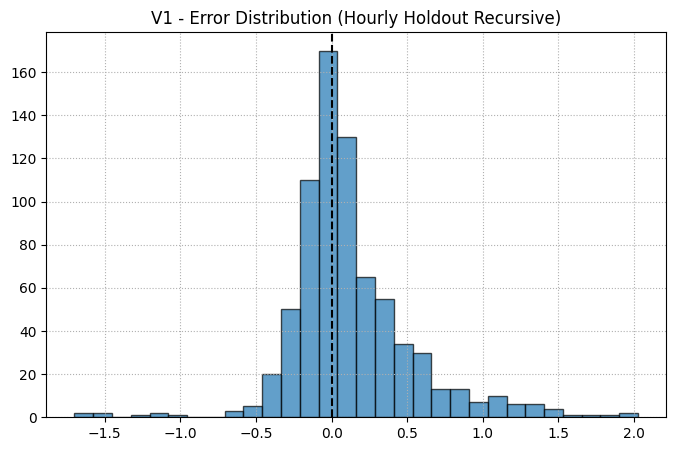

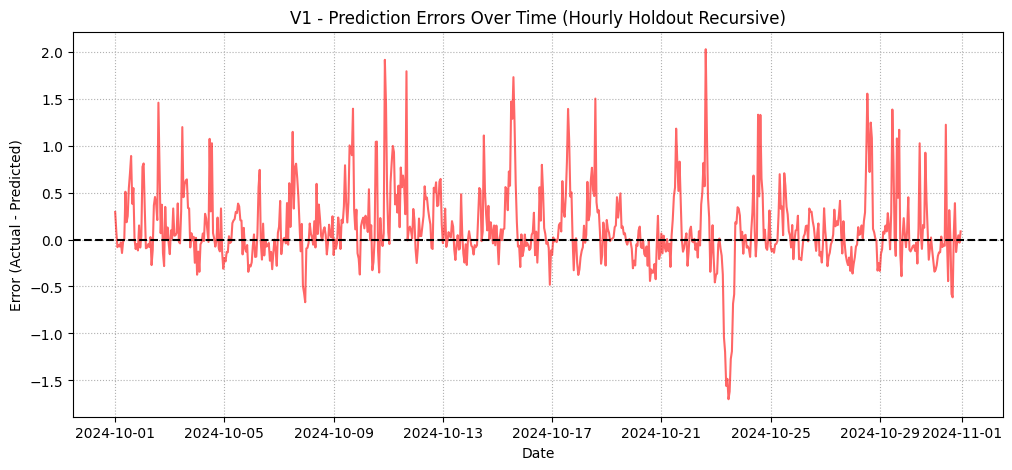

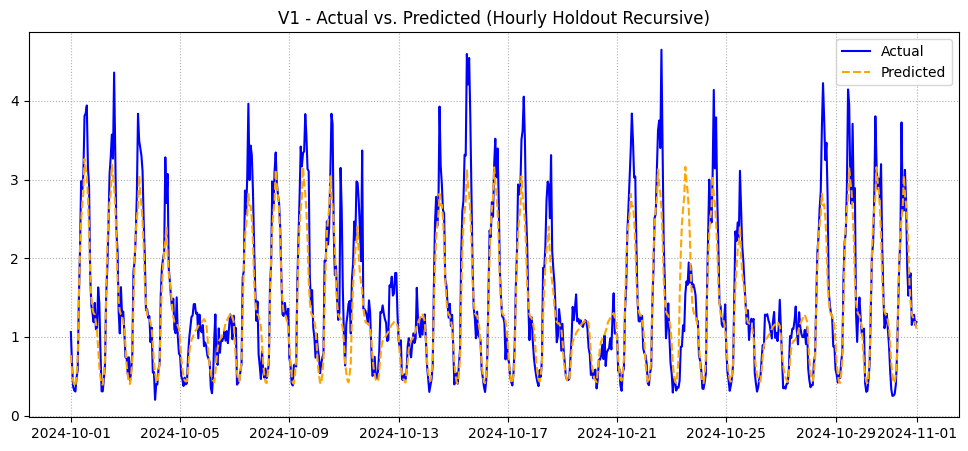

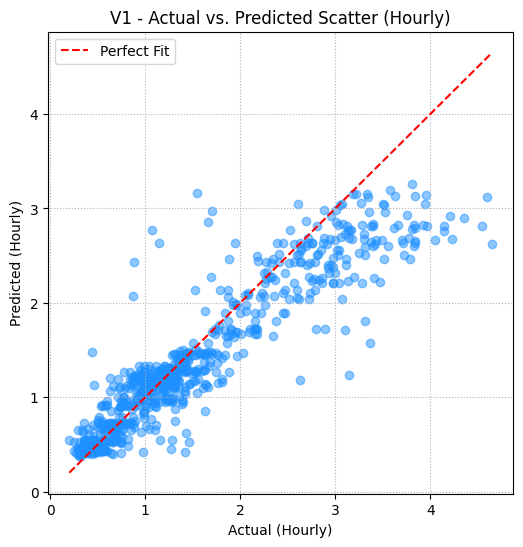


Diagnostics for V2 (Recursive Holdout)
  MAE = 0.0693
  RMSE = 0.1061
  R² = 0.7589
  Mean Error = 0.0257


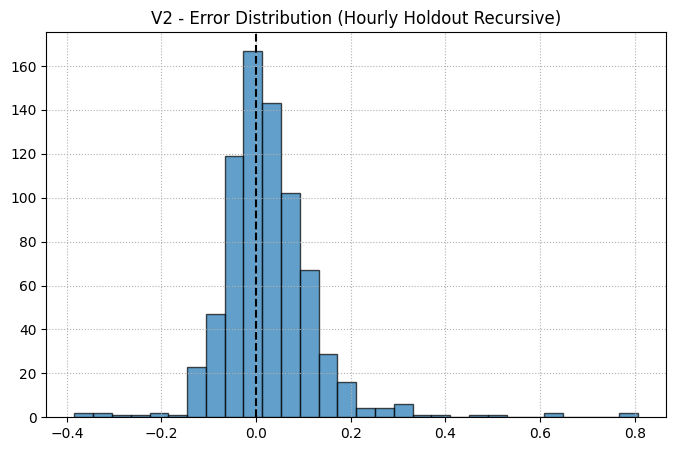

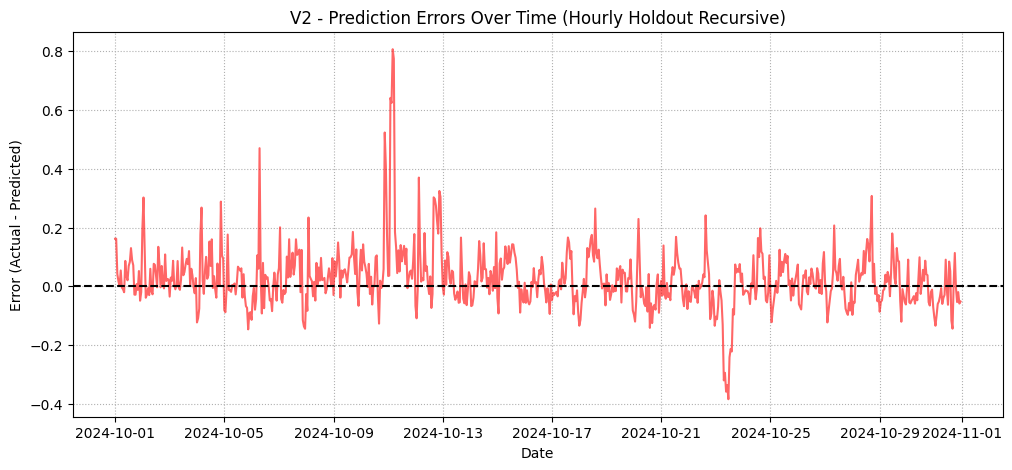

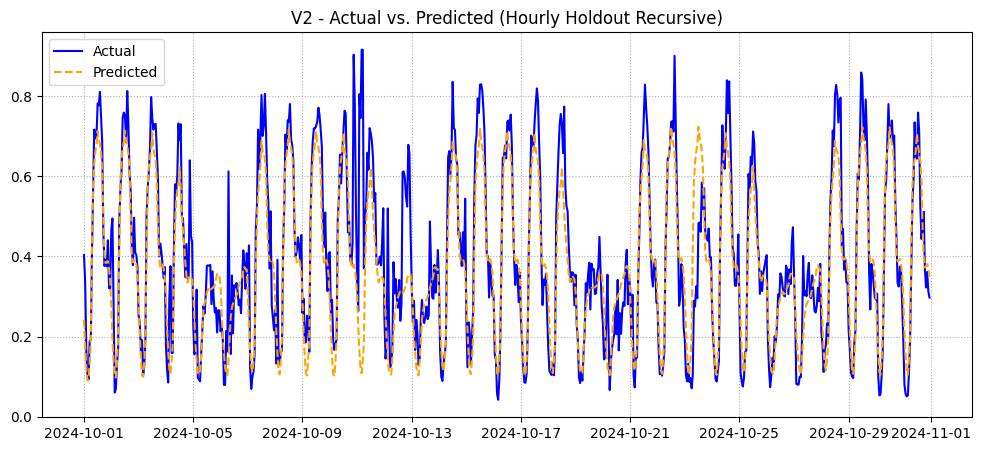

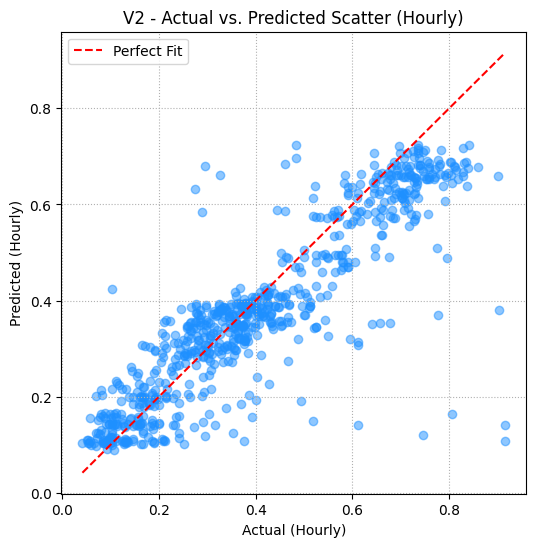

In [ ]:
# Diagnostics for Recursive Holdout
for var in ['v1', 'v2']:
    print(f"\nDiagnostics for {var.upper()} (Recursive Holdout)")

    actual = df_holdout[var]
    predicted = forecast_holdout_recursive[var]

    # Error metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    mean_err = (actual - predicted).mean()

    print(f"  MAE = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R² = {r2:.4f}")
    print(f"  Mean Error = {mean_err:.4f}")

    # 1️⃣ Error distribution plot
    errors = actual - predicted
    plt.figure(figsize=(8,5))
    plt.hist(errors.dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"{var.upper()} - Error Distribution (Hourly Holdout Recursive)")
    plt.grid(True, linestyle=':')
    plt.show()

    # 2️⃣ Error over time plot
    plt.figure(figsize=(12,5))
    plt.plot(errors.index, errors, color='red', alpha=0.6)
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"{var.upper()} - Prediction Errors Over Time (Hourly Holdout Recursive)")
    plt.xlabel("Date")
    plt.ylabel("Error (Actual - Predicted)")
    plt.grid(True, linestyle=':')
    plt.show()

    # 3️⃣ Actual vs. predicted (hourly)
    plt.figure(figsize=(12,5))
    plt.plot(actual.index, actual.values, label="Actual", color="blue")
    plt.plot(predicted.index, predicted.values, label="Predicted", color="orange", linestyle="--")
    plt.title(f"{var.upper()} - Actual vs. Predicted (Hourly Holdout Recursive)")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()

    # 4️⃣ Y-Y scatter plot (hourly)
    plt.figure(figsize=(6,6))
    plt.scatter(actual, predicted, alpha=0.5, color='dodgerblue')
    plt.plot([actual.min(), actual.max()],
             [actual.min(), actual.max()],
             color='red', linestyle='--', label='Perfect Fit')
    plt.xlabel("Actual (Hourly)")
    plt.ylabel("Predicted (Hourly)")
    plt.title(f"{var.upper()} - Actual vs. Predicted Scatter (Hourly)")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()

## Forecasting for November 2024  

After successfully validating the model on the holdout period, I proceeded to forecast for the unseen month of **November 2024**.  

### Process Overview  

- First, I redefined the **target variables** (`v1` and `v2`) and re-created the **exogenous features dataframe** using the **full dataset**.  
- I applied the same data cleaning and masking steps to ensure alignment between features and targets.  
- I then **retrained both CatBoost models** on the entire dataset, including the former holdout period, to maximize available training data and improve predictive power.  

### Forecasting Loop  

- I created an hourly datetime index for the month of November 2024 and initialized an empty dataframe for feature engineering.  
- All **time-based and static features** (like year, month, hour, holidays, and seasonal components) were engineered for November.  
- I started from the last known data point and initialized empty lists to store predictions for both `v1` and `v2`.  
- Using a recursive prediction loop (similar to the holdout process), I:  
  - Added **lagged features** by pulling either historical values or fallback from past predictions.  
  - Generated **cross-lags** (`v1` from `v2` and vice versa).  
  - Calculated **rolling means and standard deviations** over 24-hour windows.  
  - Predicted for each hourly step, appended the results to the prediction lists, and updated the last known data.  
- This loop was executed for each hour in November.  
- Once completed, I stored all results in a dataframe containing the full set of hourly forecasts.  

### Feature Importance Analysis  

- I visualized the final November forecasts to inspect the pattern and confirm the reasonableness of the results.  
- Additionally, I plotted **feature importance** for both models:  
  - For **v1**, the two most important predictors were **lagged values (v1_lag1 and v2_lag1)**, highlighting the model’s strong dependence on historical data.  
  - For **v2**, although lagged features were also important, the single most influential feature was the **hour**, indicating that the variable is more sensitive to daily seasonality.  

### Conclusion  

- The predictions were saved to CSV for future analysis and submission.  
- Overall, this recursive forecasting process allowed me to simulate realistic forecasting for an unseen future period while maintaining a structured and explainable pipeline.  

In [ ]:
# Define targets
v1_full = df['v1']
v2_full = df['v2']

# Log-transform the targets
y_full_log_v1 = np.log1p(v1_full)
y_full_log_v2 = np.log1p(v2_full)

# Make sure your exogenous features (exog_features) are already defined and aligned with df
# Make sure index alignment is enforced
y_full_log_v1 = y_full_log_v1.loc[y_full_log_v1.index.intersection(exog_features.index)]
y_full_log_v2 = y_full_log_v2.loc[y_full_log_v2.index.intersection(exog_features.index)]
exog_features = exog_features.loc[exog_features.index.intersection(y_full_log_v1.index)]

# Now apply mask to ensure no NaNs
mask_full = exog_features.notnull().all(axis=1)

# Filter again after ensuring alignment
X_full_exog = exog_features.loc[mask_full]
y_full_log_v1 = y_full_log_v1.loc[mask_full]
y_full_log_v2 = y_full_log_v2.loc[mask_full]

# Retrain models separately for v1 and v2
final_cat_v1 = clone(cat_boost_model).fit(X_full_exog, y_full_log_v1)
final_cat_v2 = clone(cat_boost_model).fit(X_full_exog, y_full_log_v2)

In [ ]:
# Define November hourly index
november_index = pd.date_range(start="2024-11-01 00:00:00", end="2024-11-30 23:00:00", freq="H")

# Create empty df_november
df_november = pd.DataFrame(index=november_index)

# Feature engineering for November
df_november["year"] = df_november.index.year
df_november["quarter"] = df_november.index.quarter
df_november["month"] = df_november.index.month
df_november["day"] = df_november.index.day
df_november["hour"] = df_november.index.hour
df_november["dayofweek"] = df_november.index.dayofweek
df_november["weekend"] = (df_november.index.dayofweek >= 5).astype(int)
df_november["hour_sin"] = np.sin(2 * np.pi * df_november["hour"] / 24)
df_november["hour_cos"] = np.cos(2 * np.pi * df_november["hour"] / 24)
df_november["dayofweek_sin"] = np.sin(2 * np.pi * df_november["dayofweek"] / 7)
df_november["dayofweek_cos"] = np.cos(2 * np.pi * df_november["dayofweek"] / 7)
df_november["is_eu_holiday"] = df_november.index.normalize().isin(
    {d for c in ["FR", "ES", "IT", "AT"] for d in holidays.CountryHoliday(c, years=[2024])}
).astype(int)
df_november["is_us_holiday"] = df_november.index.normalize().isin(
    holidays.US(years=[2024])
).astype(int)
df_november["trend"] = range(len(df_november))
df_november["trend_sq"] = df_november["trend"] ** 2

In [ ]:
# Start from all known historical data
last_known_data = df[['v1', 'v2']].copy()

# Empty lists to store predictions
predictions_v1_nov = []
predictions_v2_nov = []

# Recursive predictions
for timestamp in df_november.index:
    feature_row = df_november.loc[timestamp, [
        'year','quarter','month','day','hour','dayofweek','weekend',
        'hour_sin','hour_cos','dayofweek_sin','dayofweek_cos',
        'is_eu_holiday','is_us_holiday','trend','trend_sq'
    ]].to_dict()

    # Add lag features (use history or past predictions)
    for lag_name, lag_hours, pred_list in [
        ('v1_lag1', 1, predictions_v1_nov),
        ('v2_lag1', 1, predictions_v2_nov),
        ('v1_lag24', 24, predictions_v1_nov),
        ('v2_lag24', 24, predictions_v2_nov)
    ]:
        lag_time = timestamp - pd.Timedelta(hours=lag_hours)
        if lag_time in last_known_data.index and pd.notna(last_known_data.loc[lag_time, lag_name[:2]]):
            feature_row[lag_name] = last_known_data.loc[lag_time, lag_name[:2]]
        elif len(pred_list) >= lag_hours:
            feature_row[lag_name] = pred_list[-lag_hours]
        elif len(pred_list) > 0:
            feature_row[lag_name] = pred_list[-1]
        else:
            feature_row[lag_name] = 0

    # Cross-lags
    feature_row['v1_from_v2_lag1'] = feature_row['v2_lag1']
    feature_row['v2_from_v1_lag1'] = feature_row['v1_lag1']

    # Rolling window stats
    window_data = last_known_data.loc[
        timestamp - pd.Timedelta(hours=24): timestamp - pd.Timedelta(hours=1), ['v1', 'v2']
    ]
    if len(window_data) >= 12:
        feature_row['v1_roll24_mean'] = window_data['v1'].mean()
        feature_row['v2_roll24_mean'] = window_data['v2'].mean()
        feature_row['v1_roll24_std'] = window_data['v1'].std()
        feature_row['v2_roll24_std'] = window_data['v2'].std()
    else:
        feature_row['v1_roll24_mean'] = feature_row['v1_lag1']
        feature_row['v2_roll24_mean'] = feature_row['v2_lag1']
        feature_row['v1_roll24_std'] = 0
        feature_row['v2_roll24_std'] = 0

    # Create feature DataFrame in correct order
    feature_df = pd.DataFrame(feature_row, index=[timestamp])[exog_features.columns]

    # Predict
    pred_v1_log = final_cat_v1.predict(feature_df)
    pred_v1 = np.expm1(pred_v1_log)
    pred_v2_log = final_cat_v2.predict(feature_df)
    pred_v2 = np.expm1(pred_v2_log)

    # Store predictions
    predictions_v1_nov.append(pred_v1[0])
    predictions_v2_nov.append(pred_v2[0])

    # Update last_known_data for future steps
    last_known_data.loc[timestamp, 'v1'] = pred_v1[0]
    last_known_data.loc[timestamp, 'v2'] = pred_v2[0]

In [34]:
forecast_november = pd.DataFrame({
    'ts': df_november.index,
    'v1': predictions_v1_nov,
    'v2': predictions_v2_nov
})
forecast_november.set_index('ts', inplace=True)
forecast_november

,v1,v2
ts,,
2024-11-01 00:00:00,0.820819,0.243636
2024-11-01 01:00:00,0.547744,0.173097
2024-11-01 02:00:00,0.388423,0.118506
2024-11-01 03:00:00,0.308485,0.088396
2024-11-01 04:00:00,0.310003,0.087794
...,...,...
2024-11-30 19:00:00,1.122190,0.377825
2024-11-30 20:00:00,1.110809,0.388981
2024-11-30 21:00:00,1.096536,0.394381


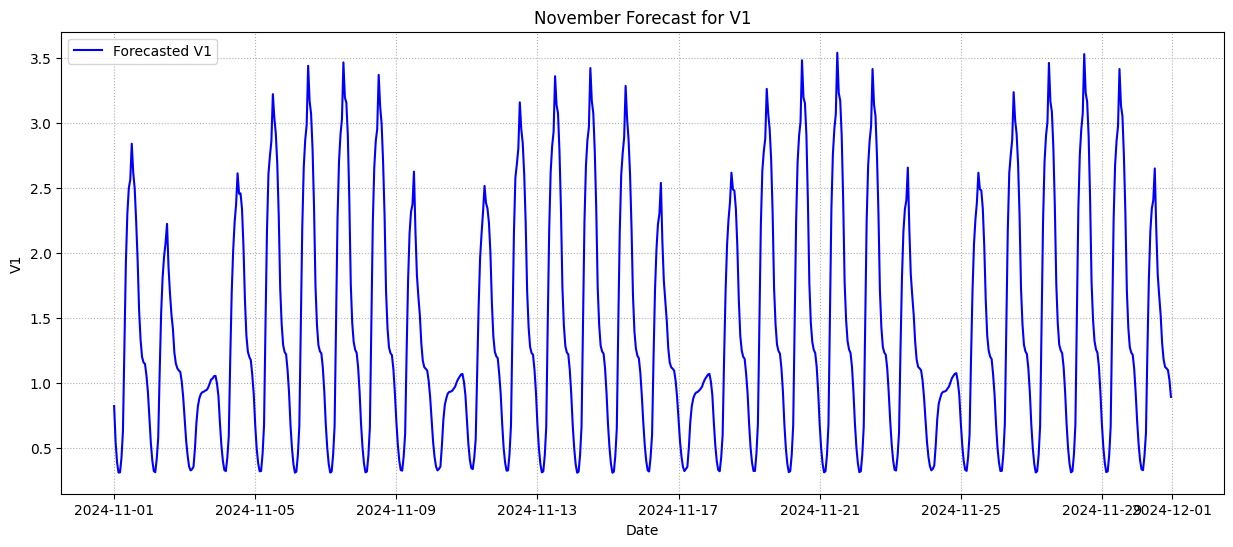

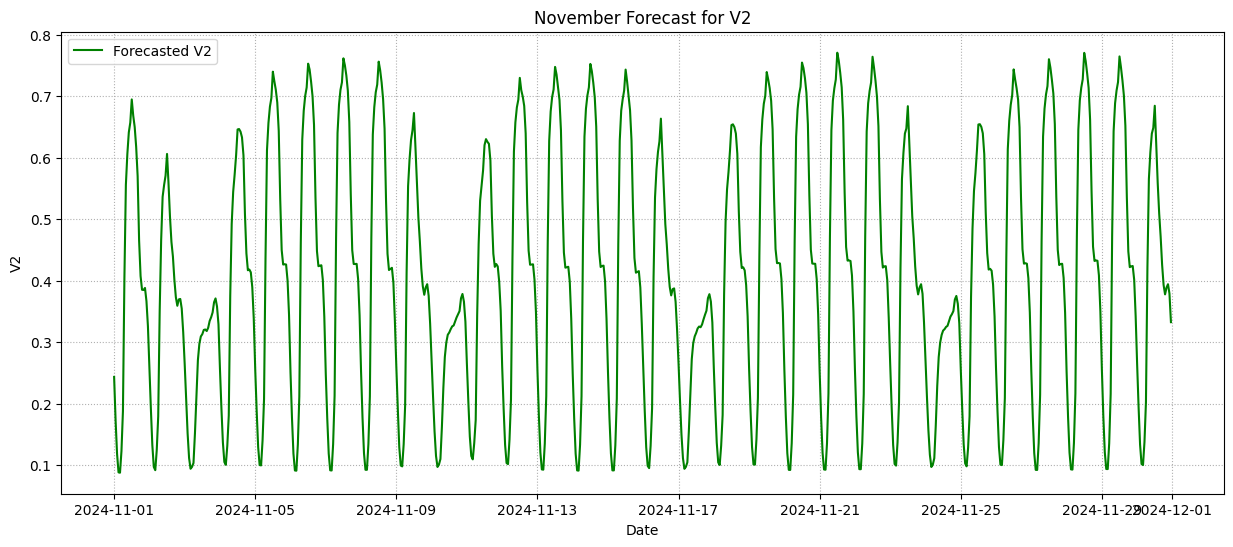

In [ ]:
# Plot forecast for V1
plt.figure(figsize=(15,6))
plt.plot(forecast_november.index, forecast_november['v1'], label='Forecasted V1', color='blue')
plt.title("November Forecast for V1")
plt.xlabel("Date")
plt.ylabel("V1")
plt.grid(True, linestyle=':')
plt.legend()
plt.show()

# Plot forecast for V2
plt.figure(figsize=(15,6))
plt.plot(forecast_november.index, forecast_november['v2'], label='Forecasted V2', color='green')
plt.title("November Forecast for V2")
plt.xlabel("Date")
plt.ylabel("V2")
plt.grid(True, linestyle=':')
plt.legend()
plt.show()

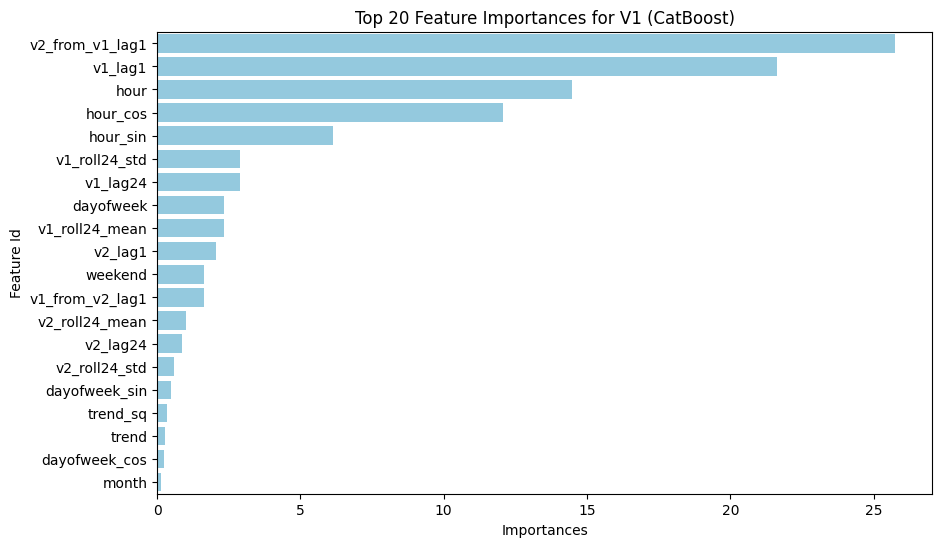

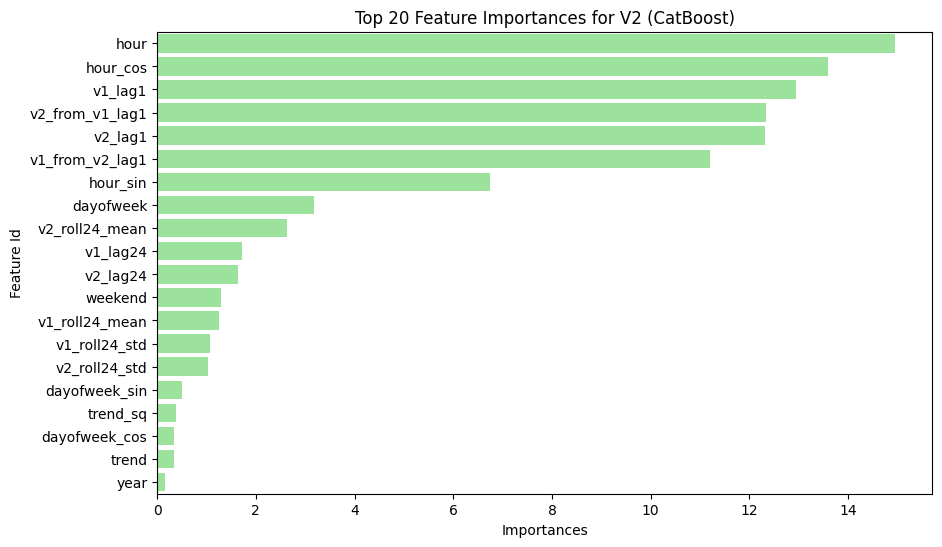

In [ ]:
importances_v1 = final_cat_v1.get_feature_importance(prettified=True)
importances_v2 = final_cat_v2.get_feature_importance(prettified=True)

# Visual plot for feature importances
plt.figure(figsize=(10, 6))

sns.barplot(
    data=importances_v1.sort_values(by="Importances", ascending=False).head(20),
    y="Feature Id", x="Importances", color="skyblue"
)
plt.title("Top 20 Feature Importances for V1 (CatBoost)")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importances_v2.sort_values(by="Importances", ascending=False).head(20),
    y="Feature Id", x="Importances", color="lightgreen"
)
plt.title("Top 20 Feature Importances for V2 (CatBoost)")
plt.show()

In [ ]:
# Save to CSV 
#forecast_november.to_csv('forecast_ghadena_hgaig.csv')